# Учебный Проект → «ГлавРосГосНефть»

## Описание Проекта

<div class="alert alert-info" role="alert">
    <span style="font-size:0.7rem">Student's note</span>
    <p class="mb-0">В коде использую <code>display()</code> намеренно, потомучто это однозначно даёт понять что планируется вывод / печать результатов. 👌</p>
</div>

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.
Шаги для выбора локации обычно такие:

1. В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
2. Строят модель для предсказания объёма запасов в новых скважинах;
3. Выбирают скважины с самыми высокими оценками значений;
4. Определяют регион с максимальной суммарной прибылью отобранных скважин;

Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.

### Условия задачи

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Загрузите и подготовьте данные. Поясните порядок действий.

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import rcParams

from statistics import mean
from statistics import stdev

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
%config InlineBackend.figure_formats = ['svg']

In [3]:
# style MATPLOTLIBRC
custom_params = {
                'figure.figsize': (10, 6),
                'figure.facecolor': '#232425',
                'figure.dpi': 240,

                'legend.frameon': False,
                'legend.borderpad': 1.4,
                'legend.labelspacing': 0.7,
                'legend.handlelength': 0.7,
                'legend.handleheight': 0.7,

                'axes.facecolor': '#232425',
                'axes.labelcolor': '#EEEEEE',
                'axes.labelpad': 17,
                'axes.spines.left': False,
                'axes.spines.bottom': False,
                'axes.spines.right': False,
                'axes.spines.top': False,
                'axes.grid': False,

                'contour.linewidth': 0.0,

                'xtick.color': '#AAAAAA',
                'ytick.color': '#AAAAAA',
                'xtick.bottom': True,
                'xtick.top': False,
                'ytick.left': True,
                'ytick.right': False,
    
                "lines.color": '#EEEEEE',

                'text.color': '#EEEEEE',
    
                'font.family': 'sans-serif',
                # 'font.sans-serif': [
                #     'Helvetica',
                #     'Verdana',
                #     'Tahoma',
                #     'Trebuchet MS',
                #     'Arial',
                #     'Chevin'
                #     ]
                }

# rcParams.update(custom_params)

In [4]:
random_seed = 108108108
dpi_k = custom_params['figure.dpi'] / rcParams['figure.dpi']
px = 1/custom_params['figure.dpi']

In [5]:
def to_px(size_px):
    px_density = int(
        round(
            size_px * px * dpi_k
        )
    )
    return px_density

In [6]:
try:
    geo_data_zero = pd.read_csv(
        './datasets/geo_data_0.csv',
        index_col='id',
    )
    geo_data_one = pd.read_csv(
        './datasets/geo_data_1.csv',
        index_col='id',
    )
    geo_data_two = pd.read_csv(
        './datasets/geo_data_2.csv',
        index_col='id',
    )
    
except FileNotFoundError:
    geo_data_zero = pd.read_csv(
        'https://code.s3.yandex.net/datasets/geo_data_0.csv',
        index_col='id',
    )
    geo_data_one = pd.read_csv(
        'https://code.s3.yandex.net/datasets/geo_data_1.csv',
        index_col='id',
    )
    geo_data_two = pd.read_csv(
        'https://code.s3.yandex.net/datasets/geo_data_2.csv',
        index_col='id',
    )
    print('FYI datasets loaded via url')

In [1]:
print(
    'Проверить дубликаты!'
)

Проверить дубликаты!


In [37]:
def plot_hist(geo_data, title='test', custom_params=custom_params):
    with mpl.rc_context(custom_params):
        fig, axs = plt.subplots(
            nrows=1,
            ncols=4,
            figsize=(
                to_px(1024), to_px(256)),
            tight_layout=True
        )
        
        n_bins = int(len(geo_data.index) / 100)
        
        for n in range(4):
            col_name = geo_data.columns[n]
            axs[n].hist(geo_data[col_name], bins=n_bins, color='forestgreen')
            axs[n].set_title(col_name)
        
        fig.suptitle(title)

        plt.show()

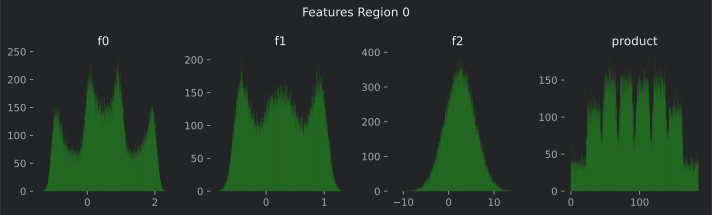

In [38]:
plot_hist(geo_data_zero, title='Features Region 0')

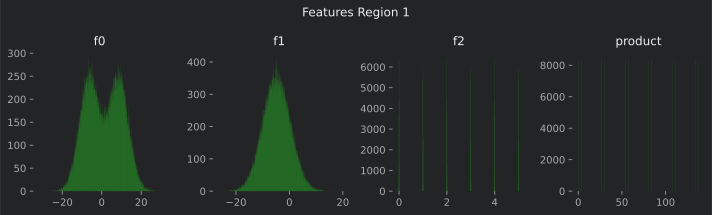

In [39]:
plot_hist(geo_data_one, title='Features Region 1')

Поэтому пройдёмся `StandardScaler` по `f2` **Первого** региона:

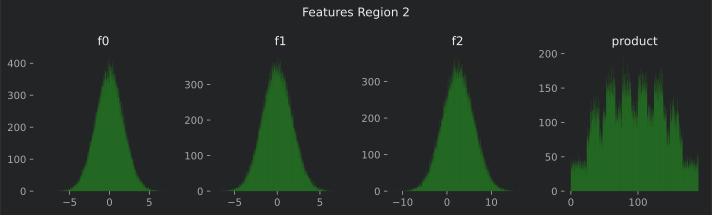

In [40]:
plot_hist(geo_data_two, title='Features Region 2')

- `id` — уникальный идентификатор скважины
- `f0`, `f1`, `f2` — три значимых признака точек
- `product` — объём запасов в скважине, (тыс. баррелей)

In [22]:
print('Region 0', end='\n\n')
display(
    geo_data_zero.info(),
    geo_data_zero.sample(5),
    geo_data_zero.describe(),
)

Region 0

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
id,,,,
chvLP,1.176526,-0.485681,1.640961,130.794024
SBcit,1.496527,-0.214473,2.307955,176.681476
ylD8L,0.775805,0.651370,1.282381,115.925748
Rk2MA,0.264267,1.067333,4.582203,114.614506
AD0dE,-0.475368,0.657783,1.485209,148.847244


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [21]:
print('Region 1', end='\n\n')
display(
    geo_data_one.info(),
    geo_data_one.sample(5),
    geo_data_one.describe(),
)

Region 1

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, kBEdx to relB0
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
id,,,,
tT6Yo,-0.296341,-3.853721,4.991961,137.945408
ZxZ2C,11.278259,-2.856078,0.003636,0.000000
jiLCi,-7.777142,-0.314281,5.004612,137.945408
7lFS4,-0.918401,-5.410907,4.000375,110.992147
yXILQ,-8.209391,-7.716579,4.996386,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [23]:
print('Region 2', end='\n\n')
display(
    geo_data_two.info(),
    geo_data_two.sample(5),
    geo_data_two.describe(),
)

Region 2

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, fwXo0 to V9kWn
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
id,,,,
zQjsq,-0.078567,0.524405,4.974080,107.448569
XwgsD,-1.161677,-3.585791,8.371536,173.336334
0ySG3,-4.830333,-0.567611,-0.545192,89.201866
ab2bm,0.974989,-0.920413,7.030534,133.830153
UvOPn,0.619179,0.007471,0.906180,13.615467


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


В **Первом** регионе распределение признака `f2` отличается от распределения признака `f2` **Нулевого** и **Второго** регионов.  
Выглядит так, что «ГлавРосГосНефть» использует **ETL** {extract > transform > load} структуру работы с данными. Похоже, что признаки были стандартизованы + масштабированы.  

**Предположим, что спросили у ETL engineer и / или Data Quality engineer:**  
1. Были ли признаки стандартизованы + масштабированы?
2. Всё ли в порядке с признаком `f2` **Первом** регионе?  

**Предположи, что отет от ETL engineer и / или Data Quality engineer:**  
> 1. Да, всё окай.
> 2. Лучше не бывает.


<hr/>

## Обучите и проверьте модель для каждого региона

In [ ]:
features_zero = geo_data_zero.drop('product', axis=1)
target_zero = geo_data_zero['product']

features_one = geo_data_one.drop('product', axis=1)
target_one = geo_data_one['product']

features_two = geo_data_two.drop('product', axis=1)
target_two = geo_data_two['product']

### Разбейте данные на обучающую и валидационную выборки в соотношении 75:25

In [51]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_,
    target_,
    test_size=0.25,
    random_state=random_seed,
)

### Обучите модель и сделайте предсказания на валидационной выборке

### Сохраните предсказания и правильные ответы на валидационной выборке

### Напечатайте на экране средний запас предсказанного сырья и RMSE модели

### Проанализируйте результаты

<hr/>

## Подготовьтесь к расчёту прибыли

### Все ключевые значения для расчётов сохраните в отдельных переменных

### Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины

### Сравните полученный объём сырья со средним запасом в каждом регионе

### Напишите выводы по этапу подготовки расчёта прибыли

### 

<hr/>

## Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели

### Выберите скважины с максимальными значениями предсказаний

### Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям

### Рассчитайте прибыль для полученного объёма сырья

### 

### 

<hr/>

## Посчитайте риски и прибыль для каждого региона

### Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли

### Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков

#### Убыток — это отрицательная прибыль 

### Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор

### 

<hr/>

## 

## Как будут проверять мой проект?

- Как вы готовите данные к обучению?
- Выполнили все шаги по инструкции?
- Все ли условия бизнеса учтены?
- Какие выводы об исследовании задачи делаете?
- Корректно ли выполнена процедура Bootstrap?
- Предложен ли регион для разработки скважин? Обоснован ли выбор?
- Не дублируете ли код?
- Следите ли за структурой проекта и поддерживаете ли аккуратность кода?